In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys
sys.path.append('/home/noamtal/python/2019/results gnn vs no mes no hid/check message passing/helper_functions')

import uproot
import numpy as np
import pandas as pd
import glob
import networkx as nx
import dgl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from file_loading import *
from pdg_id_dict import *
from helper_functions import *
from graph_edm import *
from graph_plotting import *
from dataset_functions import *
from gnn_model import *
from edge_model_double import *

In [2]:
flist = ['/home/noamtal/python/2019/Dataset/test/f_11_bjets.h5',
 '/home/noamtal/python/2019/Dataset/test/f_11_cjets.h5']

In [3]:
flist_ujets = ['/home/noamtal/python/2019/Dataset/test/f_11_ujets.h5']

In [4]:
flist_valid = [
 '/home/noamtal/python/2019/Dataset/test/f_0_bjets.h5',
 '/home/noamtal/python/2019/Dataset/test/f_0_cjets.h5',
 '/home/noamtal/python/2019/Dataset/test/f_0_ujets.h5']

In [5]:
df_list = []
for fname in flist:
	f = h5py.File(fname,'r')
	keylist = [x for x in f.keys()]
	f.close()
	print(keylist)
	df_list.append(pd.concat( [pd.read_hdf(fname,key=x)  for x in keylist] ) )

graph_df = pd.concat( df_list )

['df_0', 'df_1', 'df_10', 'df_11', 'df_12', 'df_13', 'df_14', 'df_15', 'df_16', 'df_17', 'df_18', 'df_19', 'df_2', 'df_20', 'df_21', 'df_22', 'df_23', 'df_24', 'df_25', 'df_26', 'df_27', 'df_28', 'df_3', 'df_4', 'df_5', 'df_6', 'df_7', 'df_8', 'df_9']
['df_0', 'df_1', 'df_10', 'df_11', 'df_12', 'df_13', 'df_14', 'df_15', 'df_16', 'df_17', 'df_18', 'df_19', 'df_2', 'df_20', 'df_21', 'df_22', 'df_23', 'df_24', 'df_25', 'df_26', 'df_27', 'df_28', 'df_3', 'df_4', 'df_5', 'df_6', 'df_7', 'df_8', 'df_9']


In [6]:
graph_df = pd.concat( df_list )

In [7]:
graph_df = graph_df.sample(frac=0.16).reset_index(drop=True)

In [8]:
df_list = []
for fname in flist_ujets:
	f = h5py.File(fname,'r')
	keylist = [x for x in f.keys()]
	f.close()
	print(keylist)
	df_list.append(pd.concat( [pd.read_hdf(fname,key=x)  for x in keylist] ) )

['df_0', 'df_1', 'df_10', 'df_11', 'df_12', 'df_13', 'df_14', 'df_15', 'df_16', 'df_17', 'df_18', 'df_19', 'df_2', 'df_20', 'df_21', 'df_22', 'df_23', 'df_24', 'df_25', 'df_26', 'df_27', 'df_28', 'df_3', 'df_4', 'df_5', 'df_6', 'df_7', 'df_8', 'df_9']


In [9]:
graph_df_ujets = pd.concat( df_list )

In [10]:
graph_df_ujets = graph_df_ujets.sample(frac=0.03).reset_index(drop=True)

In [11]:
graph_df = pd.concat([graph_df,graph_df_ujets])

In [12]:
df_list = []
for fname in flist_valid:
	f = h5py.File(fname,'r')
	keylist = [x for x in f.keys()]
	f.close()
	print(keylist)
	df_list.append(pd.concat( [pd.read_hdf(fname,key=x)  for x in keylist] ) )

['df_0', 'df_1', 'df_2', 'df_3']
['df_0', 'df_1', 'df_2', 'df_3']
['df_0', 'df_1', 'df_2', 'df_3']


In [13]:
graph_df_valid = pd.concat( df_list )

In [14]:
ds = JetGraphDataset([graph_df])
ds_valid = JetGraphDataset([graph_df_valid])

In [15]:
dataset_loader = torch.utils.data.DataLoader(ds,
											 batch_size=10, shuffle=True,collate_fn=create_batch_edges,
											 num_workers=1)

In [16]:
dataset_loader_valid = torch.utils.data.DataLoader(ds_valid,
											 batch_size=150, shuffle=False,collate_fn=create_batch_edges,
											 num_workers=1)

In [17]:
ce_loss = nn.CrossEntropyLoss(reduction='mean')
bce_loss = nn.BCEWithLogitsLoss()
bce_loss_withoutLogists = nn.BCELoss()

In [18]:
def loss_function(yhat,edge_labels,node_labels):
	node_class = yhat[0]
	edge_class = yhat[1]
	node_edge_attention =  yhat[2]
	edge_edge_attention = yhat[3]

	batch_s = len(node_class)
	
	node_labels[ node_labels < 2 ] = 0
	node_labels[ node_labels > 1 ] = 1
	
	node_loss = ce_loss(node_class,node_labels)
	
	edge_loss = bce_loss(edge_class,edge_labels)
	
	node_edge_loss = bce_loss_withoutLogists(node_edge_attention,edge_labels)
	edge_edge_loss = bce_loss_withoutLogists(edge_edge_attention,edge_labels)

	return node_loss+edge_loss+node_edge_loss+edge_edge_loss

In [19]:
def node_loss_function(yhat,edge_labels,node_labels):
	node_class = yhat[0]
	edge_class = yhat[1]
	
	node_labels[ node_labels < 2 ] = 0
	node_labels[ node_labels > 1 ] = 1
	
	node_loss = ce_loss(node_class,node_labels)
	
	return node_loss

In [20]:
def edge_loss_function(yhat,edge_labels,node_labels):
	node_class = yhat[0]
	edge_class = yhat[1]
	
	edge_loss = bce_loss(edge_class,edge_labels)
	
	return edge_loss

In [21]:
gnn_double = JetEdgeClassifierDoubleChannel(hidden_size=128)

In [21]:
??gnn_double.forward

In [ ]:
for name, param in model.state_dict().items()

In [22]:
import fastai
from fastai import *
from fastai.vision import *

In [23]:
db = DataBunch(train_dl=dataset_loader,valid_dl=dataset_loader_valid,collate_fn=create_batch_edges,fix_dl=dataset_loader)

In [24]:
learn_2 = Learner(db,gnn_double,loss_func=loss_function)

In [25]:
def write_to_file(filename,trainloss,valloss):
	f = open(filename,'a')
	n_batches = len(trainloss)
	for batch_i in range(n_batches):
		if batch_i!=n_batches-1:
			f.write(str(trainloss[batch_i])+'\n')
		else:
			f.write(str(trainloss[batch_i])+'\t'+str(valloss)+'\n')
	f.close()

In [28]:
for epoch_i in range(100):
	
	if epoch_i in [0,1]:
		lr = 1e-03
	elif epoch_i in range(2,10):
		lr = 1e-04
	else:
		lr = 1e-05

In [29]:
	learn_2.fit(10,lr=lr)

epoch,train_loss,valid_loss,time
0,0.658554,0.629768,10:33
1,0.660577,0.616790,10:24
2,0.645563,0.617226,11:03
3,0.665630,0.606589,10:39
4,0.659968,0.590449,10:59
5,0.625021,0.585071,10:44
6,0.646029,0.601162,10:57
7,0.636650,0.569303,10:50
8,0.623481,0.590054,11:31
9,0.637780,0.567968,11:06


In [30]:
	train_loss = np.array([x.item() for x in learn_2.recorder.losses])

In [32]:
	val_loss = learn_2.recorder.val_losses[0]

In [33]:
	write_to_file('/home/noamtal/python/2019/results gnn vs no mes no hid/check message passing/model_gnn_auxEloss_loss_10_epochs.txt',train_loss,val_loss)

In [39]:
	torch.save(gnn_double, '/home/noamtal/Desktop/model_gnn_auxEloss_'+str(epoch_i)+'.pt')

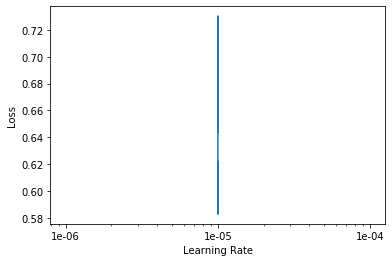

In [35]:
learn_2.recorder.plot()

In [ ]:
DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

In [68]:
gnn_double.node_classifier.node_edge_attention

AttributeError: 'JetEdgeClassifier_1' object has no attribute 'node_edge_attention'

In [90]:
train_loss

array([0.721541, 0.68197 , 0.71556 , 0.660614, ..., 0.640957, 0.639314, 0.637151, 0.63778 ])